# Q2 Image Colourization 

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from datetime import datetime
from tqdm import tqdm
import torch.optim as optim
import os

## Color Centroids and Data Prepration

Color centroids shape: (24, 3)
Color centroids range: [12.70, 246.06]


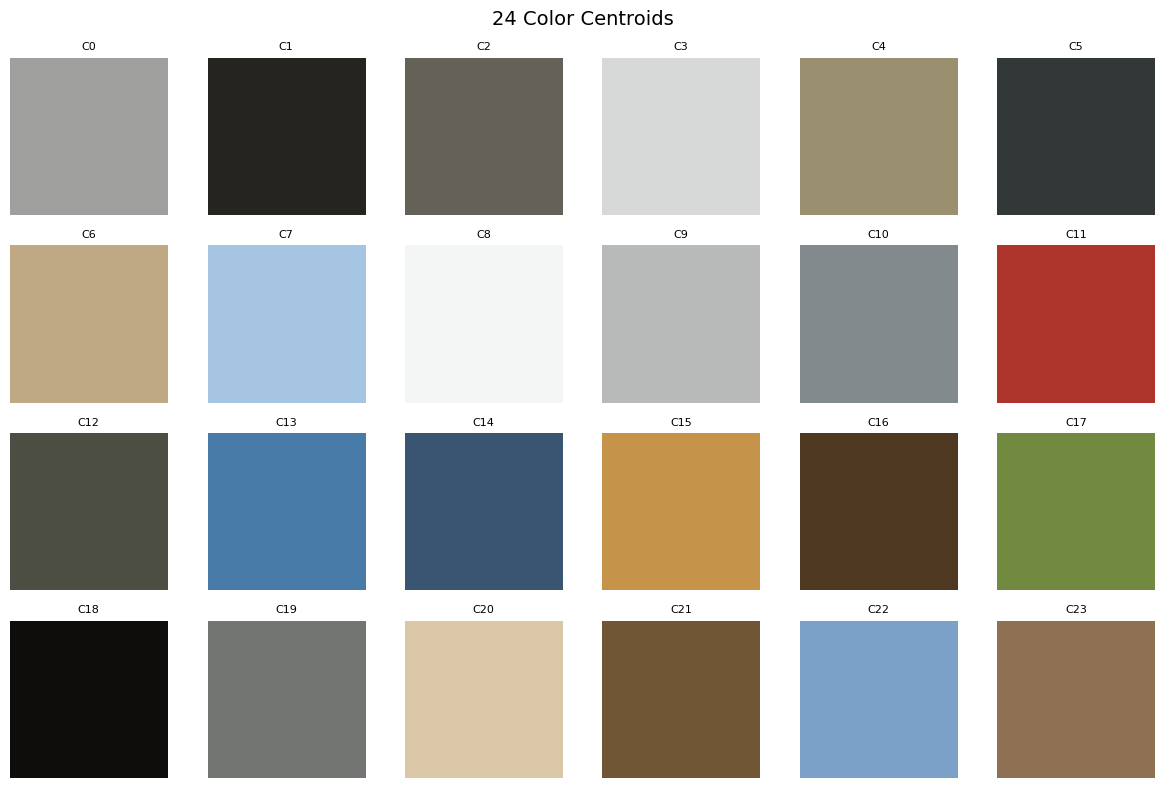

In [2]:
# Load color centroids
color_centroids = np.load('color_centroids.npy')
print(f"Color centroids shape: {color_centroids.shape}")
print(f"Color centroids range: [{color_centroids.min():.2f}, {color_centroids.max():.2f}]")

# Visualize the 24 color centroids
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axes = axes.flatten()

for i in range(24):
    # Create a small square with the centroid color
    color_square = np.ones((10, 10, 3)) * color_centroids[i] / 255.0
    axes[i].imshow(color_square)
    axes[i].set_title(f'C{i}', fontsize=8)
    axes[i].axis('off')

plt.suptitle('24 Color Centroids', fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
def rgb_to_grayscale(rgb_image):
    """
    Convert RGB image to grayscale using standard weights
    Args:
        rgb_image: numpy array of shape (H, W, 3) with values in [0, 255]
    Returns:
        grayscale_image: numpy array of shape (H, W) with values in [0, 255]
    """
    # Standard RGB to grayscale conversion weights
    weights = np.array([0.33, 0.33, 0.33])
    grayscale = np.dot(rgb_image, weights)
    return grayscale.astype(np.uint8)

def assign_color_labels(rgb_image, centroids):
    """
    Assign each pixel to the nearest color centroid
    Args:
        rgb_image: numpy array of shape (H, W, 3) with values in [0, 255]
        centroids: numpy array of shape (24, 3) with color centroids
    Returns:
        labels: numpy array of shape (H, W) with values in {0, ..., 23}
    """
    H, W, _ = rgb_image.shape
    # Reshape image to (H*W, 3) for efficient distance computation
    pixels = rgb_image.reshape(-1, 3).astype(np.float32)
    
    # Compute distances to all centroids for all pixels
    # pixels: (H*W, 3), centroids: (24, 3)
    # distances: (H*W, 24)
    distances = np.linalg.norm(pixels[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    
    # Find nearest centroid for each pixel
    labels = np.argmin(distances, axis=1)
    
    # Reshape back to (H, W)
    return labels.reshape(H, W)

# Test the functions with a sample
print("Testing color assignment functions...")
test_rgb = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8)
test_gray = rgb_to_grayscale(test_rgb)
test_labels = assign_color_labels(test_rgb, color_centroids)

print(f"Test RGB shape: {test_rgb.shape}")
print(f"Test grayscale shape: {test_gray.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Label range: [{test_labels.min()}, {test_labels.max()}]")

Testing color assignment functions...
Test RGB shape: (32, 32, 3)
Test grayscale shape: (32, 32)
Test labels shape: (32, 32)
Label range: [0, 23]


In [4]:
class CIFAR10ColorizationDataset(Dataset):
    """
    Custom dataset for CIFAR-10 colorization task
    """
    def __init__(self, cifar_dataset, color_centroids, transform=None):
        """
        Args:
            cifar_dataset: Original CIFAR-10 dataset
            color_centroids: numpy array of shape (24, 3) with color centroids
            transform: Optional transform to be applied on the grayscale input
        """
        self.cifar_dataset = cifar_dataset
        self.color_centroids = color_centroids
        self.transform = transform
        
    def __len__(self):
        return len(self.cifar_dataset)
    
    def __getitem__(self, idx):
        # Get original RGB image and class (we ignore the class for colorization)
        rgb_image, _ = self.cifar_dataset[idx]
        
        # Convert PIL Image to numpy array if needed
        if hasattr(rgb_image, 'numpy'):
            rgb_array = rgb_image.numpy().transpose(1, 2, 0)  # CHW to HWC
        else:
            rgb_array = np.array(rgb_image)
        
        # Ensure values are in [0, 255] range
        if rgb_array.max() <= 1.0:
            rgb_array = (rgb_array * 255).astype(np.uint8)
        
        # Convert to grayscale
        grayscale = rgb_to_grayscale(rgb_array)
        
        # Assign color labels
        color_labels = assign_color_labels(rgb_array, self.color_centroids)
        
        # Convert to tensors
        # Grayscale: normalize to [0, 1] and add channel dimension
        grayscale_tensor = torch.from_numpy(grayscale).float() / 255.0
        grayscale_tensor = grayscale_tensor.unsqueeze(0)  # Add channel dimension: (1, H, W)
        
        # Color labels: keep as long tensor for cross-entropy loss
        labels_tensor = torch.from_numpy(color_labels).long()  # (H, W)
        
        # Apply transform to grayscale input if provided
        if self.transform:
            grayscale_tensor = self.transform(grayscale_tensor)
        
        return grayscale_tensor, labels_tensor

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")

# Define transforms (minimal for now, can be expanded later)
train_transform = transforms.Compose([
    transforms.ToTensor(),  # This will be applied to the original RGB, but we'll handle conversion manually
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load original CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='../../../data', train=True, download=True, transform=None)
cifar_test = datasets.CIFAR10(root='../../../data', train=False, download=True, transform=None)

print(f"CIFAR-10 train size: {len(cifar_train)}")
print(f"CIFAR-10 test size: {len(cifar_test)}")

# Create colorization datasets
train_dataset = CIFAR10ColorizationDataset(cifar_train, color_centroids)
test_dataset = CIFAR10ColorizationDataset(cifar_test, color_centroids)

print(f"Colorization train dataset size: {len(train_dataset)}")
print(f"Colorization test dataset size: {len(test_dataset)}")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 train size: 50000
CIFAR-10 test size: 10000
Colorization train dataset size: 50000
Colorization test dataset size: 10000


Testing dataset and visualization...
Grayscale batch shape: torch.Size([8, 1, 32, 32])
Labels batch shape: torch.Size([8, 32, 32])
Grayscale range: [0.000, 0.980]
Labels range: [0, 23]


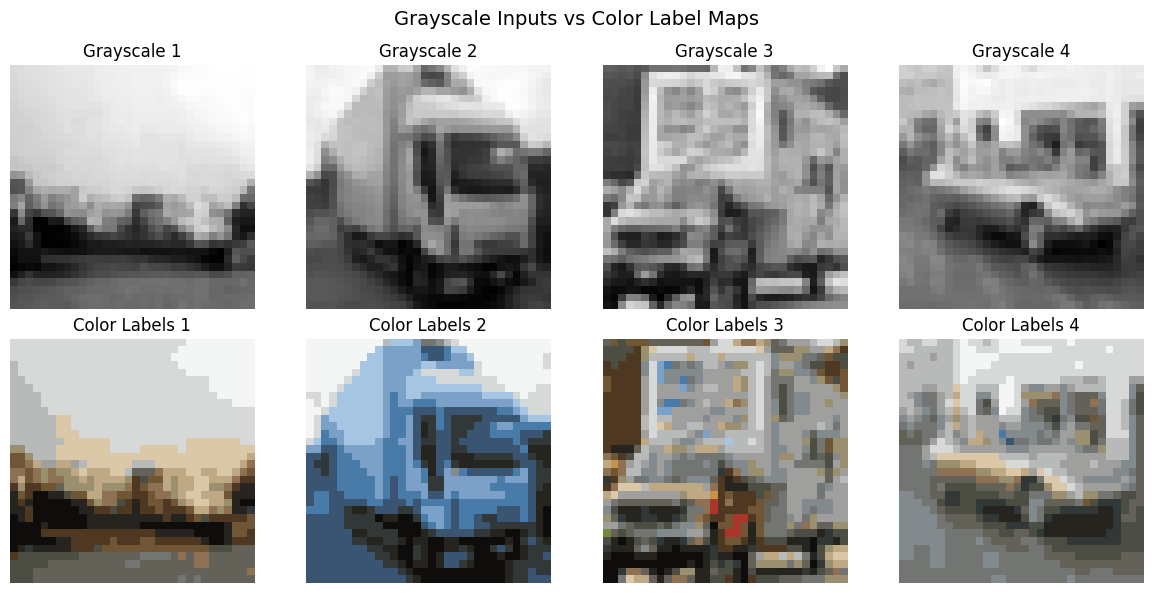

In [5]:
# Test the dataset and visualize some samples
print("Testing dataset and visualization...")

# Create a small subset for testing
test_indices = np.random.choice(len(train_dataset), 8, replace=False)
test_subset = Subset(train_dataset, test_indices)
test_loader = DataLoader(test_subset, batch_size=8, shuffle=False)

# Get a batch
grayscale_batch, labels_batch = next(iter(test_loader))

print(f"Grayscale batch shape: {grayscale_batch.shape}")  # Should be [8, 1, 32, 32]
print(f"Labels batch shape: {labels_batch.shape}")       # Should be [8, 32, 32]
print(f"Grayscale range: [{grayscale_batch.min():.3f}, {grayscale_batch.max():.3f}]")
print(f"Labels range: [{labels_batch.min()}, {labels_batch.max()}]")

# Visualize samples
def visualize_colorization_samples(grayscale_batch, labels_batch, color_centroids, num_samples=4):
    """Visualize grayscale inputs and their corresponding color label maps"""
    fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))
    
    for i in range(num_samples):
        # Grayscale input
        gray_img = grayscale_batch[i, 0].numpy()  # Remove channel dimension
        axes[0, i].imshow(gray_img, cmap='gray')
        axes[0, i].set_title(f'Grayscale {i+1}')
        axes[0, i].axis('off')
        
        # Color label map - convert labels back to RGB for visualization
        labels = labels_batch[i].numpy()
        rgb_reconstruction = color_centroids[labels] / 255.0  # Convert to [0,1] for display
        axes[1, i].imshow(rgb_reconstruction)
        axes[1, i].set_title(f'Color Labels {i+1}')
        axes[1, i].axis('off')
    
    plt.suptitle('Grayscale Inputs vs Color Label Maps', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_colorization_samples(grayscale_batch, labels_batch, color_centroids)

In [6]:
# Create train/validation split
print("Creating train/validation split...")

# Split training data into train and validation (80/20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size], 
                                       generator=torch.Generator().manual_seed(42))

print(f"Train subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 64  # Can be adjusted based on GPU memory

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Verify data shapes
sample_gray, sample_labels = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Input (grayscale): {sample_gray.shape}")   # Should be [batch_size, 1, 32, 32]
print(f"Target (labels): {sample_labels.shape}")   # Should be [batch_size, 32, 32]

Creating train/validation split...
Train subset size: 40000
Validation subset size: 10000
Test dataset size: 10000
Number of training batches: 625
Number of validation batches: 157
Number of test batches: 157



Sample batch shapes:
Input (grayscale): torch.Size([64, 1, 32, 32])
Target (labels): torch.Size([64, 32, 32])


## Model Architecture

In [7]:

class Model(nn.Module):

    def __init__(self, num__filter, num_input_channel, kernel_size, number_of_classes=24):
        super().__init__()
        
        # --- FIX: Padding is only for the encoder ---
        # (kernel_size=3 -> enc_padding=1)
        # (kernel_size=5 -> enc_padding=2)
        enc_padding = (kernel_size - 1) // 2

        ##### ENCODER (Correctly uses variable kernel_size)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=num_input_channel, out_channels=num__filter, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=num__filter, out_channels=num__filter*2, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels=num__filter*2, out_channels=num__filter*4, kernel_size=kernel_size, padding=enc_padding),
            nn.BatchNorm2d(num__filter*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        ##### DECODER (FIXED: Hard-coded to match diagram)

        self.dc1 = nn.Sequential(
            # Diagram specifies kernel=2, stride=2. No padding needed.
            nn.ConvTranspose2d(in_channels=num__filter*4, out_channels=num__filter*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(num__filter*2),
            nn.ReLU()
        )

        self.dc2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=num__filter*2, out_channels=num__filter, kernel_size=2, stride=2),  
            nn.BatchNorm2d(num__filter),
            nn.ReLU()
        )

        self.dc3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=num__filter, out_channels=number_of_classes, kernel_size=2, stride=2),
            nn.BatchNorm2d(number_of_classes),
            nn.ReLU()
        )

        ### CLASSIFIER (Correct, matches diagram)
        self.classifier = nn.Conv2d(in_channels=number_of_classes, out_channels=number_of_classes, kernel_size=1)
        
    def forward(self, x):
        # --- ADDED: The required forward pass ---
        
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Decoder
        d1 = self.dc1(e3)
        d2 = self.dc2(d1)
        d3 = self.dc3(d2)
        
        # Classifier
        output = self.classifier(d3)
        
        # Output is [B, NC, 32, 32]
        return output

## Training and Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import wandb
import numpy as np # <-- Needed for image conversion

# --- Helper function to create RGB images from labels ---
# This converts your label map back into a viewable color image
def labels_to_rgb(label_map, centroids):
    """Converts a [H, W] label map to a [H, W, 3] RGB image."""
    # .cpu().numpy() is important if the map is on the GPU
    label_map = label_map.cpu().numpy()
    rgb_image = centroids[label_map]
    return rgb_image.astype(np.uint8)

# --- Helper function to make grayscale viewable ---
def grayscale_to_rgb(gray_tensor):
    """Converts a [1, H, W] grayscale tensor to a [H, W, 3] RGB image."""
    gray_np = gray_tensor.squeeze(0).cpu().numpy() # Squeeze to [H, W]
    rgb_image = np.stack([gray_np, gray_np, gray_np], axis=-1)
    return (rgb_image * 255).astype(np.uint8)
# --------------------------------------------------------

config = {
    "learning_rate": 0.01,
    "batch_size": 64, 
    "num_epochs": 25,
    "num_filters": 16,
    "kernel_size": 3,
    "optimizer": "Adam"
}

wandb.init(
    project="q2-cifar",
    name="ye_basic_h",
    config=config 
)

model = Model(
    num__filter=config["num_filters"], 
    num_input_channel=1, 
    kernel_size=config["kernel_size"], 
    number_of_classes=24
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

optim = optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()
num_epochs = config["num_epochs"]

best_val_loss = float('inf')
save_path = 'checkpoints/basic_model.pth'

os.makedirs(os.path.dirname(save_path), exist_ok=True)
print(f"Checkpoints will be saved to {save_path}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "validation_loss": avg_val_loss
    })

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved to {save_path} (Val Loss: {avg_val_loss:.4f})")

print("\nFinished Training.")

print("Generating example colorizations...")

model.load_state_dict(torch.load(save_path))
model.eval() 
# Get one batch of validation data
with torch.no_grad():
    inputs, labels = next(iter(val_loader)) # Get a batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs) 
    
    # Convert logits to final class predictions
    # We take the argmax along the channel (dim=1)
    predicted_labels = torch.argmax(outputs, dim=1) # Shape [B, 32, 32]

# [cite_start]Log the first 10 images from the batch [cite: 224]
example_images = []
for i in range(10):
    # Get the i-th image/label from the batch
    gray_input = inputs[i]
    ground_truth_labels = labels[i]
    pred_labels = predicted_labels[i]

    # Convert all three to RGB numpy arrays
    gray_rgb = grayscale_to_rgb(gray_input)
    truth_rgb = labels_to_rgb(ground_truth_labels, color_centroids)
    pred_rgb = labels_to_rgb(pred_labels, color_centroids)
    
    # Add to list for wandb
    example_images.append(wandb.Image(
        gray_rgb, 
        caption=f"Image {i}: Input Grayscale"
    ))
    example_images.append(wandb.Image(
        pred_rgb, 
        caption=f"Image {i}: Predicted Color"
    ))
    example_images.append(wandb.Image(
        truth_rgb, 
        caption=f"Image {i}: Ground Truth"
    ))

# Log the list of images to wandb under the key "Colorization Examples"
wandb.log({"Colorization Examples": example_images})
print("Logged 10 example images to wandb.")

# --- 4. SAVE BEST MODEL AND FINISH ---
wandb.save(save_path)
print(f"Best model {save_path} saved to wandb.")

wandb.finish()

wandb: Currently logged in as: nidhish-jain (nidhish-jain-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda
Checkpoints will be saved to checkpoints/basic_model.pth


Epoch 1/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 26.19it/s]



Epoch [1/25], Train Loss: 2.0323, Val Loss: 1.8649
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8649)


Epoch 2/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.57it/s]



Epoch [2/25], Train Loss: 1.8701, Val Loss: 1.8271
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8271)


Epoch 3/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.59it/s]



Epoch [3/25], Train Loss: 1.8183, Val Loss: 1.8148
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.8148)


Epoch 4/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.74it/s]



Epoch [4/25], Train Loss: 1.7992, Val Loss: 1.8266


Epoch 5/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.78it/s]



Epoch [5/25], Train Loss: 1.7845, Val Loss: 1.7434
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7434)


Epoch 6/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.40it/s]



Epoch [6/25], Train Loss: 1.7764, Val Loss: 1.7604


Epoch 7/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.64it/s]



Epoch [7/25], Train Loss: 1.7656, Val Loss: 1.7275
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7275)


Epoch 8/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.65it/s]



Epoch [8/25], Train Loss: 1.7575, Val Loss: 1.7102
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.7102)


Epoch 9/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 29.01it/s]



Epoch [9/25], Train Loss: 1.7544, Val Loss: 1.7484


Epoch 10/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.99it/s]



Epoch [10/25], Train Loss: 1.7546, Val Loss: 1.7790


Epoch 11/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.49it/s]



Epoch [11/25], Train Loss: 1.7366, Val Loss: 1.7709


Epoch 12/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 29.02it/s]



Epoch [12/25], Train Loss: 1.7378, Val Loss: 1.7200


Epoch 13/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]



Epoch [13/25], Train Loss: 1.7380, Val Loss: 1.7382


Epoch 14/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.82it/s]



Epoch [14/25], Train Loss: 1.7283, Val Loss: 1.7980


Epoch 15/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.66it/s]



Epoch [15/25], Train Loss: 1.7284, Val Loss: 1.6969
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6969)


Epoch 16/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.46it/s]



Epoch [16/25], Train Loss: 1.7227, Val Loss: 1.7007


Epoch 17/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 29.01it/s]



Epoch [17/25], Train Loss: 1.7160, Val Loss: 1.7028


Epoch 18/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.66it/s]



Epoch [18/25], Train Loss: 1.7161, Val Loss: 1.7129


Epoch 19/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.90it/s]



Epoch [19/25], Train Loss: 1.7185, Val Loss: 1.6952
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6952)


Epoch 20/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.75it/s]



Epoch [20/25], Train Loss: 1.7150, Val Loss: 1.6890
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6890)


Epoch 21/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 29.09it/s]



Epoch [21/25], Train Loss: 1.7081, Val Loss: 1.7482


Epoch 22/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.46it/s]



Epoch [22/25], Train Loss: 1.7070, Val Loss: 1.6859
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6859)


Epoch 23/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.58it/s]



Epoch [23/25], Train Loss: 1.7052, Val Loss: 1.6864


Epoch 24/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 28.59it/s]



Epoch [24/25], Train Loss: 1.7031, Val Loss: 1.6705
New best model saved to checkpoints/basic_model.pth (Val Loss: 1.6705)


Epoch 25/25 [Validation]: 100%|██████████| 157/157 [00:05<00:00, 27.90it/s]


Epoch [25/25], Train Loss: 1.6988, Val Loss: 1.6706

Finished Training.
Generating example colorizations...



/tmp/ipykernel_1593000/1911269574.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Logged 10 example images to wandb.
Best model checkpoints/basic_model.pth saved to wandb.


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_loss,█▇▆▇▄▄▃▂▄▅▅▃▃▆▂▂▂▃▂▂▄▂▂▁▁
epoch,25
train_loss,1.69884
validation_loss,1.6706


## Analytical Questions

####  1. Number of Weights 

So in this architecture we have the following layers:
1. Input grayscale (since grayscale so Cin = 1) to the first conv2d layer: (NIC -> NF) so we have NF * NIC * K^2 weights
#### 2. Number of Outputs

For each layer, the number of outputs is calculated as the total number of activation elements in the output tensor. This is given by the product of the batch size (B), the number of output channels, and the spatial dimensions of the output (H × W).

for stride = 1, padding = (k-1)/2
| Layer                          | Input Shape         | Output Shape        | Weights Count                      | Bias Count | Connections Count                                                                 | Outputs Count                     |
|--------------------------------|---------------------|---------------------|------------------------------------|------------|----------------------------------------------------------------------------------|-----------------------------------|
| Input                          | [B, NIC, 32, 32]   | [B, NIC, 32, 32]   | 0                                  | 0          | 0                                                                                | B * NIC * 32 * 32                |
| Conv2d (NIC → NF) + BN + ReLU + MaxPool2d | [B, NIC, 32, 32]   | [B, NF, 16, 16]   | NF * NIC * K^2                     | NF         | NF * NIC * K^2 * (16 * 16)                                                      | B * NF * 16 * 16                 |
| Conv2d (NF → 2NF) + BN + ReLU + MaxPool2d | [B, NF, 16, 16]    | [B, 2NF, 8, 8]    | 2NF * NF * K^2                     | 2NF        | 2NF * NF * K^2 * (8 * 8)                                                      | B * 2NF * 8 * 8                  |
| Conv2d (2NF → 4NF) + BN + ReLU + MaxPool2d | [B, 2NF, 8, 8]     | [B, 4NF, 4, 4]    | 4NF * 2NF * K^2                    | 4NF        | 4NF * 2NF * K^2 * (4 * 4)                                                       | B * 4NF * 4 * 4                  |
| ConvTranspose2d (4NF → 2NF) + BN + ReLU | [B, 4NF, 4, 4]     | [B, 2NF, 8, 8]    | 4NF * 2NF * 2^2                    | 2NF        | 4NF * 2NF * 2^2 * (8 * 8)                                                       | B * 2NF * 8 * 8                  |
| ConvTranspose2d (2NF → NF) + BN + ReLU | [B, 2NF, 8, 8]     | [B, NF, 16, 16]   | 2NF * NF * 2^2                     | NF         | 2NF * NF * 2^2 * (16 * 16)                                                        | B * NF * 16 * 16                 |
| ConvTranspose2d (NF → NC) + BN + ReLU | [B, NF, 16, 16]    | [B, NC, 32, 32]   | NF * NC * 2^2                      | NC         | NF * NC * 2^2 * (32 * 32)                                                       | B * NC * 32 * 32                 |
| Conv2d 1 × 1 (NC → NC)         | [B, NC, 32, 32]    | [B, NC, 32, 32]    | NC * NC * 1^2                      | NC         | NC * NC * 1^2 * (32 * 32)                                                       | B * NC  * 32 * 32                |


Total weights = 
K^2×(NF×NIC+2×NF^2+8×N^2)+4×(8NF^2+4N^2+NF×NC)+NC^2

Total outputs/activations = Bx(NFx16x16 + 2NFx8x8 + 4NFx4x4 + 2NFx8x8 + NFx16x16 + NCx32x32 + NCx32x32 + NICx32x32)

Total Number of Connections =  [NF × NIC × K² × 16 × 16] +  [2NF × NF × K² × 8 × 8] + [4NF × 2NF × K² × 4 × 4] + [2NF × 4NF × 4 × 8 × 8] + [NF × 2NF × 4 × 16 × 16] + [NC × NF × 4 × 32 × 32] + [NC × NC × 1 × 32 × 32]

Now on increasing the number of input spatial size is increased that is from 32x32 to 64x64  we will see the output size will become double as the pooling/stride halves the spatial size at each of the layers. So only the output sizes and the number of connections will be affected. The number of weights and biases will remain same as they depend on the number of channels and kernel sizes which are not changing.
#### 2. Number of Outputs (Input: 64x64)

For stride = 1, padding = (k-1)/2
| Layer                          | Input Shape         | Output Shape        | Weights Count                      | Bias Count | Connections Count                                                                 | Outputs Count                     |
|--------------------------------|---------------------|---------------------|------------------------------------|------------|----------------------------------------------------------------------------------|-----------------------------------|
| Input                          | [B, NIC, 64, 64]   | [B, NIC, 64, 64]   | 0                                  | 0          | 0                                                                                | B * NIC * 64 * 64                |
| Conv2d (NIC → NF) + BN + ReLU + MaxPool2d | [B, NIC, 64, 64]   | [B, NF, 32, 32]   | NF * NIC * K^2                     | NF         | NF * NIC * K^2 * (32 * 32)                                                      | B * NF * 32 * 32                 |
| Conv2d (NF → 2NF) + BN + ReLU + MaxPool2d | [B, NF, 32, 32]    | [B, 2NF, 16, 16]  | 2NF * NF * K^2                     | 2NF        | 2NF * NF * K^2 * (16 * 16)                                                      | B * 2NF * 16 * 16                |
| Conv2d (2NF → 4NF) + BN + ReLU + MaxPool2d | [B, 2NF, 16, 16]   | [B, 4NF, 8, 8]    | 4NF * 2NF * K^2                    | 4NF        | 4NF * 2NF * K^2 * (8 * 8)                                                       | B * 4NF * 8 * 8                  |
| ConvTranspose2d (4NF → 2NF) + BN + ReLU | [B, 4NF, 8, 8]     | [B, 2NF, 16, 16]  | 4NF * 2NF * 2^2                    | 2NF        | 4NF * 2NF * 2^2 * (16 * 16)                                                     | B * 2NF * 16 * 16                |
| ConvTranspose2d (2NF → NF) + BN + ReLU | [B, 2NF, 16, 16]   | [B, NF, 32, 32]   | 2NF * NF * 2^2                     | NF         | 2NF * NF * 2^2 * (32 * 32)                                                      | B * NF * 32 * 32                 |
| ConvTranspose2d (NF → NC) + BN + ReLU | [B, NF, 32, 32]    | [B, NC, 64, 64]   | NF * NC * 2^2                      | NC         | NF * NC * 2^2 * (64 * 64)                                                       | B * NC * 64 * 64                 |
| Conv2d 1 × 1 (NC → NC)         | [B, NC, 64, 64]    | [B, NC, 64, 64]    | NC * NC * 1^2                      | NC         | NC * NC * 1^2 * (64 * 64)                                                       | B * NC  * 64 * 64                |


Total outputs/activations = Bx(NFx32x32 + 2NFx16x16 + 4NFx8x8 + 2NFx16x16 + NFx32x32 + NCx64x64 + NCx64x64 + NICx64x64)

Total Number of Connections =  [NF × NIC × K² × 32 × 32] + [2NF × NF × K² × 16 × 16]+ [4NF × 2NF × K² × 8 × 8] + [2NF × 4NF × 4 × 16 × 16] + [NF × 2NF × 4 × 32 × 32] + [NC × NF × 4 × 64 × 64] + [NC × NC × 1 × 64 × 64]


## Hyperparameter Tuning

In [ ]:
# --- Make sure these are defined in the global scope ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataset = val_subset  # Ensure this is set if not already

print("--- Defining Sweep Configuration ---")

sweep_config = {
    'name': 'cifar-colorization-sweep',
    'method': 'random',
    'metric': {
        'name': 'validation_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {'values': [1e-4, 3e-4, 1e-3, 3e-3]},
        'batch_size': {'values': [32, 64, 128]},
        'num_filters': {'values': [8, 16, 32]},
        'kernel_size': {'values': [3, 5]},
        'optimizer': {'values': ['Adam', 'SGD']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="q2-cifar")
print(f"\nSweep initialized. SWEEP_ID: {sweep_id}")
print("--- You can now run Cell 2 to start the agent ---")

def labels_to_rgb(label_map, centroids):
    label_map = label_map.cpu().numpy()
    rgb_image = centroids[label_map]
    return rgb_image.astype(np.uint8)

def grayscale_to_rgb(gray_tensor):
    gray_np = gray_tensor.squeeze(0).cpu().numpy()
    rgb_image = np.stack([gray_np, gray_np, gray_np], axis=-1)
    return (rgb_image * 255).astype(np.uint8)

def train_wrapper():
    run = wandb.init()
    config = wandb.config

    # --- Set run name to include all hyperparameters ---
    run_name = (
        f"bs{config.batch_size}_ks{config.kernel_size}_lr{config.learning_rate}_"
        f"nf{config.num_filters}_opt{config.optimizer}"
    )
    wandb.run.name = run_name
    print(f"--- Starting Run: {run_name} ---")
    print(f"Config: {dict(config)}")

    try:
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
    except NameError:
        print("Error: 'train_dataset' or 'val_dataset' not found.")
        print("Please make sure they are defined in your notebook's global scope before running the agent.")
        wandb.finish()
        return

    model = Model(
        num__filter=config.num_filters,
        num_input_channel=1,
        kernel_size=config.kernel_size,
        number_of_classes=24
    ).to(device)

    if config.optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    num_epochs = 25
    best_val_loss = float('inf')
    save_path = f'checkpoints/{run_name}.pth'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    print(f"Checkpoints will be saved to {save_path}")
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        log_dict = {
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "validation_loss": avg_val_loss,
            "best_validation_loss": best_val_loss
        }
        log_dict.update(dict(config))
        wandb.log(log_dict)

    print(f"\nFinished Training for {run_name}. Best Val Loss: {best_val_loss:.4f}")

    print("Generating example colorizations...")
    model.load_state_dict(torch.load(save_path))
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(val_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)

    example_images = []
    for i in range(min(10, config.batch_size)):
        gray_input = inputs[i]
        ground_truth_labels = labels[i]
        pred_labels = predicted_labels[i]
        gray_rgb = grayscale_to_rgb(gray_input)
        truth_rgb = labels_to_rgb(ground_truth_labels, color_centroids)
        pred_rgb = labels_to_rgb(pred_labels, color_centroids)
        example_images.append(wandb.Image(gray_rgb, caption=f"Image {i}: Input Grayscale"))
        example_images.append(wandb.Image(pred_rgb, caption=f"Image {i}: Predicted Color"))
        example_images.append(wandb.Image(truth_rgb, caption=f"Image {i}: Ground Truth"))
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(gray_rgb, cmap='gray')
        plt.title(f"Image {i}: Input Grayscale")
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(pred_rgb)
        plt.title(f"Image {i}: Predicted Color")
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(truth_rgb)
        plt.title(f"Image {i}: Ground Truth")
        plt.axis('off')
        plt.show()

    wandb.log({"Colorization Examples": example_images})
    print("Logged example images.")
    wandb.save(save_path)
    print(f"Best model {save_path} saved to wandb.")
    wandb.finish()

print(f"\n--- Starting Wandb Agent for Sweep {sweep_id} ---")
print("This will run 20 times. You can stop this cell at any time.")
wandb.agent(sweep_id, function=train_wrapper, count=20)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7fcf977ec8e0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7fd08b3910d0, raw_cell="
# --- Cell 1: Define the Sweep (Run this once) --.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bgnode078/home2/nidhishj/assignment_smai/assignment-4-Nidhishj/Q2/code.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

--- Defining Sweep Configuration ---


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: y28m6rq5
Sweep URL: https://wandb.ai/nidhish-jain-iiit-hyderabad/q2-cifar/sweeps/y28m6rq5

Sweep initialized. SWEEP_ID: y28m6rq5
--- You can now run Cell 2 to start the agent ---

--- Starting Wandb Agent for Sweep y28m6rq5 ---
This will run 20 times. You can stop this cell at any time.


Exception in thread Thread-43:
Traceback (most recent call last):
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/site-packages/wandb/agents/pyagent.py", line 296, in _run_job
    wandb.teardown()
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/site-packages/wandb/sdk/wandb_setup.py", line 480, in teardown
    orig_singleton._teardown(exit_code=exit_code)
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/site-packages/wandb/sdk/wandb_setup.py", line 314, in _teardown
    internal_exit_code = connection.teardown(exit_code or 0)
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/site-packages/wandb/sdk/lib/service/service_connection.py", line 190, in teardown
    self._client.send_server_request(
  File "/home2/nidhishj/miniconda3/envs/torch_env/lib/python3.9/site-packages/wandb/sdk/lib/sock_client.py",

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7fcf977ec8e0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7fd08b3912b0, execution_count=11 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7fd08b3910d0, raw_cell="
# --- Cell 1: Define the Sweep (Run this once) --.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bgnode078/home2/nidhishj/assignment_smai/assignment-4-Nidhishj/Q2/code.ipynb#X21sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe